
Forecasting Steam Cost


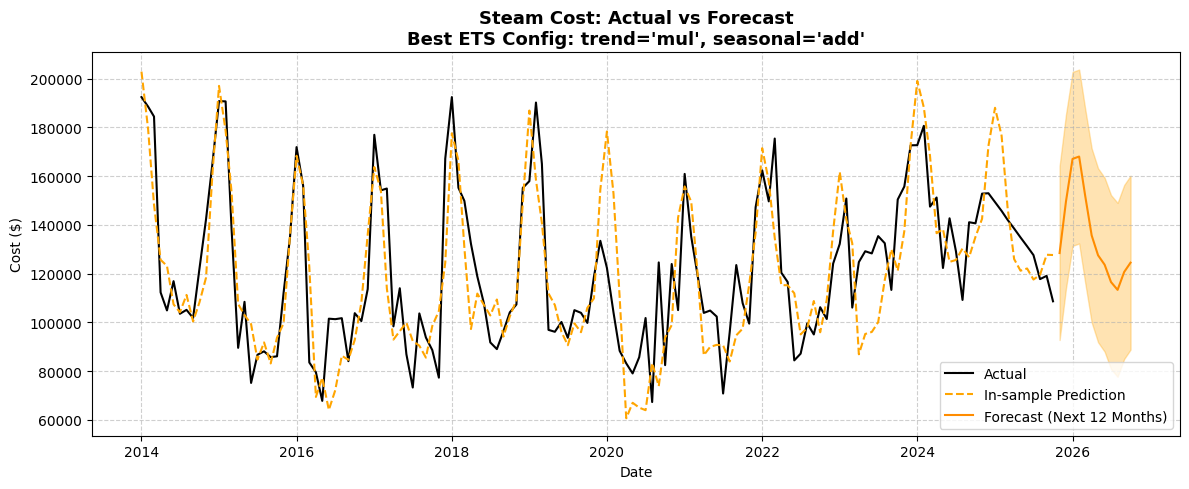


Forecasting Electric Cost


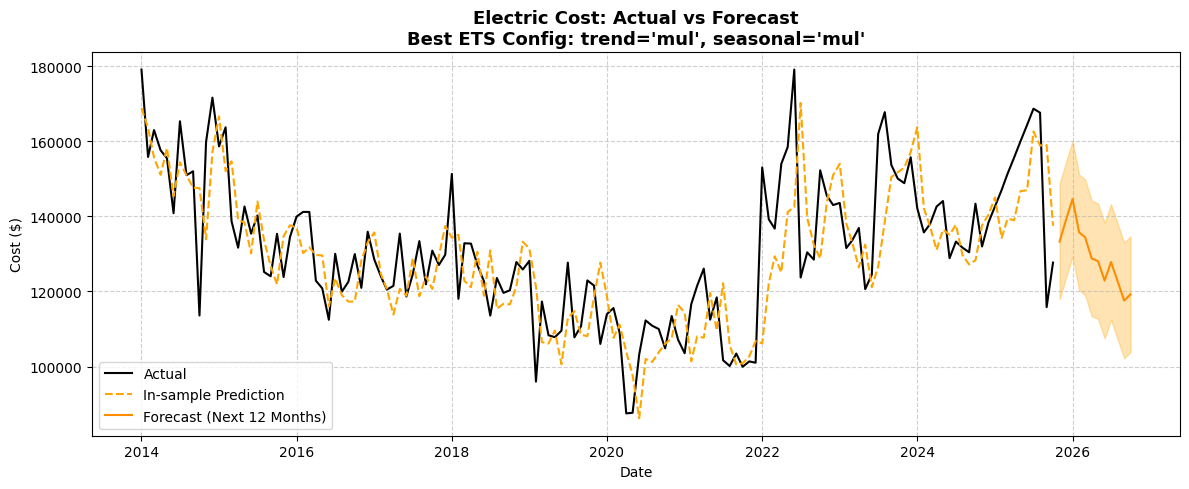


Forecasting Chilled Water Cost


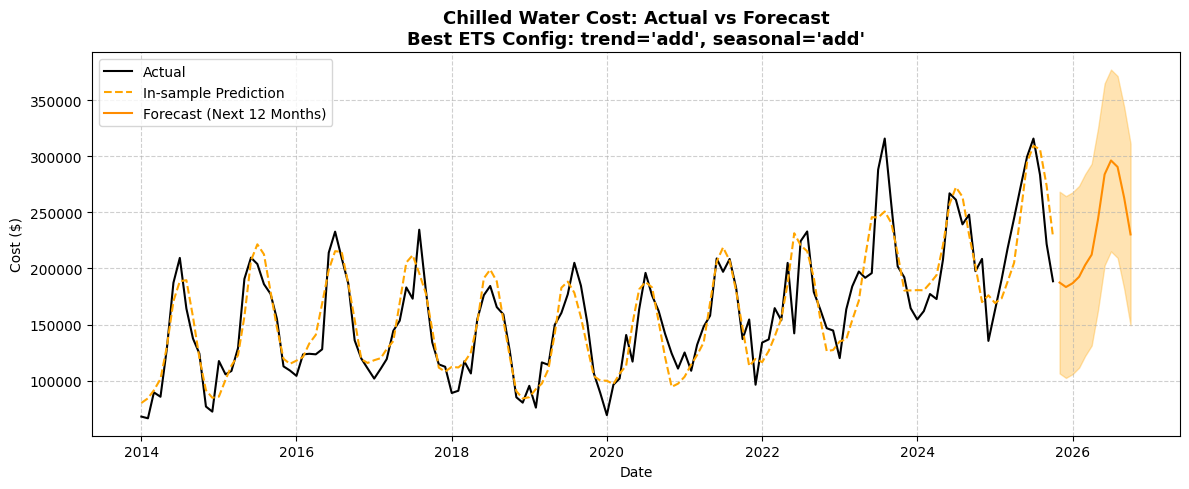


Forecasting Solar Cost


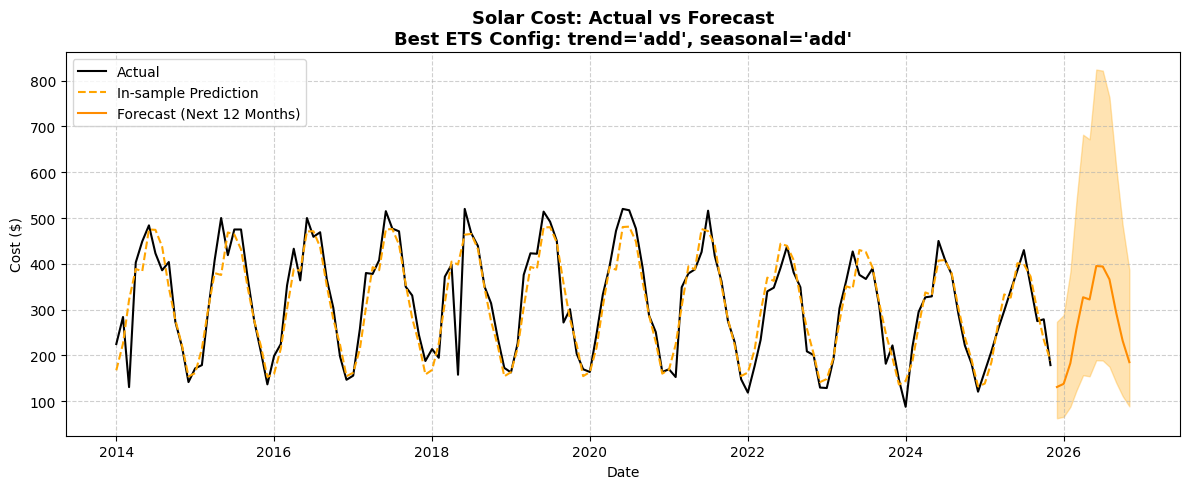


Forecasting Natural Gas Cost


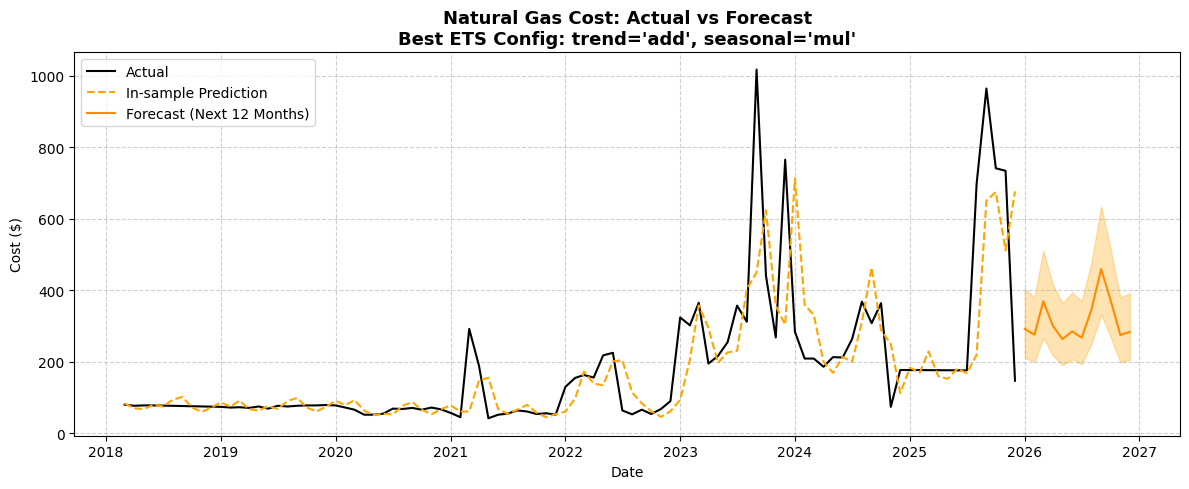

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import DateOffset
import warnings

warnings.filterwarnings("ignore")

# Function to find best ETS config
def best_ets_model(series, seasonal_periods=12):
    configs = [('add', 'add'), ('add', 'mul'), ('mul', 'add'), ('mul', 'mul')]
    best_rmse = float('inf')
    best_fit = None
    best_model = None

    for trend, seasonal in configs:
        try:
            model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            pred = model_fit.fittedvalues
            rmse = np.sqrt(((series - pred) ** 2).mean())
            if rmse < best_rmse:
                best_rmse = rmse
                best_fit = model_fit
                best_model = (trend, seasonal)
        except Exception:
            continue

    return best_fit, best_model

file_path = "/Users/ecebaltacioglu/my_project/venv_ece/sortedenergy.xlsx"
df = pd.read_excel(file_path, sheet_name='in')
df.columns = df.columns.str.strip()
df['formatted date'] = pd.to_datetime(df['formatted date'])
df.set_index('formatted date', inplace=True)
df = df.sort_index()

cost_columns = ['Steam Cost', 'Electric Cost', 'Chilled Water Cost', 'Solar Cost', 'Natural Gas Cost']

for cost_column in cost_columns:
    print(f"\nForecasting {cost_column}")
    
    try:
        series = pd.to_numeric(df[cost_column], errors='coerce')
        series = series[series > 0].dropna().asfreq('MS').interpolate()

        if len(series) < 24:
            print(f"Not enough data for {cost_column}. Skipping.")
            continue

        cap = series.quantile(0.99)
        series = series.clip(upper=cap)

        # Optional log transform
        log_transform = False
        if (series > 0).all() and series.max() / series.min() > 5:
            log_transform = True
            series = np.log(series)

        forecast_index = [series.index[-1] + DateOffset(months=i) for i in range(1, 13)]

        model_fit, (trend, seasonal) = best_ets_model(series)
        forecast = model_fit.forecast(12)
        lower_bound = forecast - 1.96 * np.std(forecast)
        upper_bound = forecast + 1.96 * np.std(forecast)
        fitted = model_fit.fittedvalues

        # Reverse log transform if applied
        if log_transform:
            series = np.exp(series)
            fitted = np.exp(fitted)
            forecast = np.exp(forecast)
            lower_bound = np.exp(lower_bound)
            upper_bound = np.exp(upper_bound)

        plt.figure(figsize=(12, 5))
        plt.plot(series, label='Actual', color='black')
        plt.plot(fitted, label='In-sample Prediction', linestyle='--', color='orange')
        plt.plot(forecast_index, forecast, label='Forecast (Next 12 Months)', color='darkorange')
        plt.fill_between(forecast_index, lower_bound, upper_bound, color='orange', alpha=0.3)

        plt.title(f"{cost_column}: Actual vs Forecast\nBest ETS Config: trend='{trend}', seasonal='{seasonal}'", fontsize=13, weight='bold')
        plt.xlabel("Date")
        plt.ylabel("Cost ($)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        save_path = f"/Users/ecebaltacioglu/my_project/venv_ece/{cost_column.replace(' ', '_')}_forecast.png"
        plt.savefig(save_path, dpi=300)
        plt.show()

    except Exception as e:
        print(f"Error forecasting {cost_column}: {e}")



Steam Cost


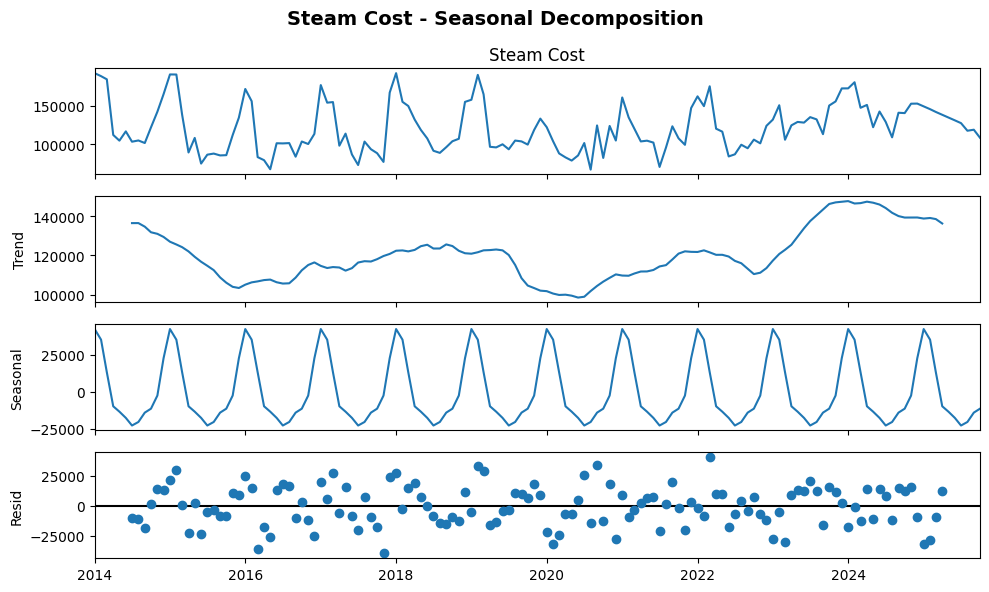


Electric Cost


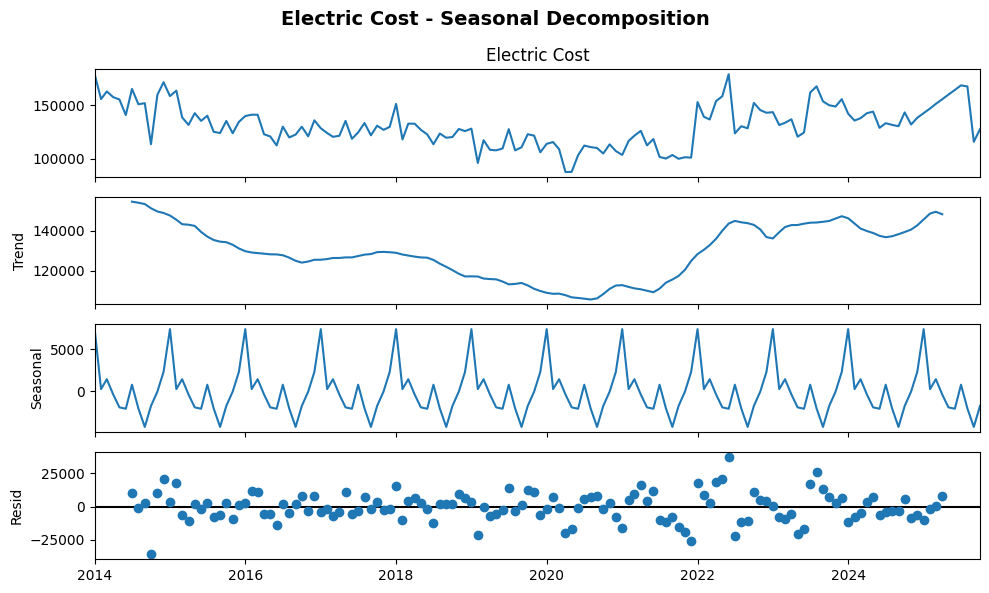


Chilled Water Cost


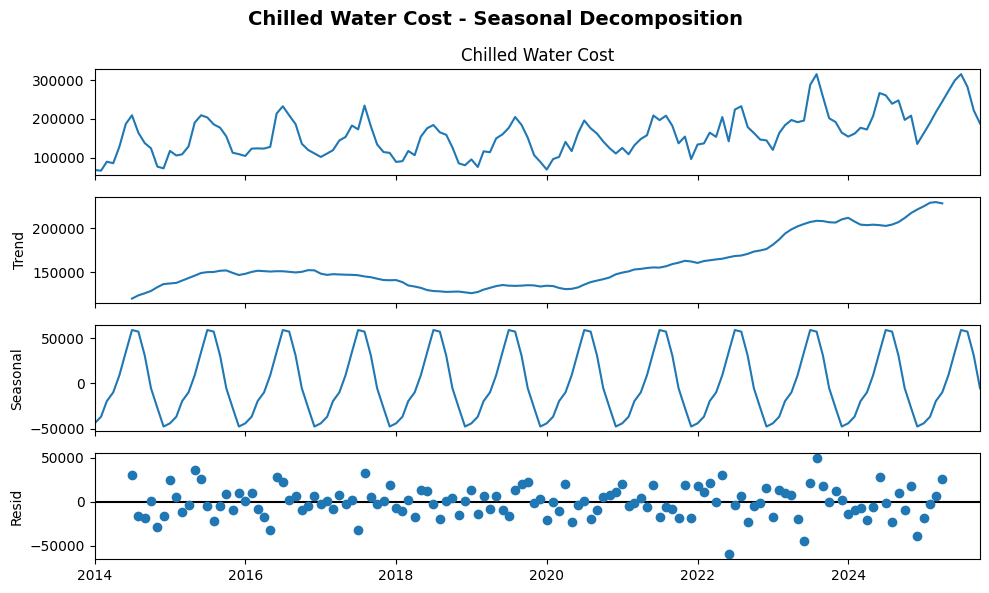


Solar Cost


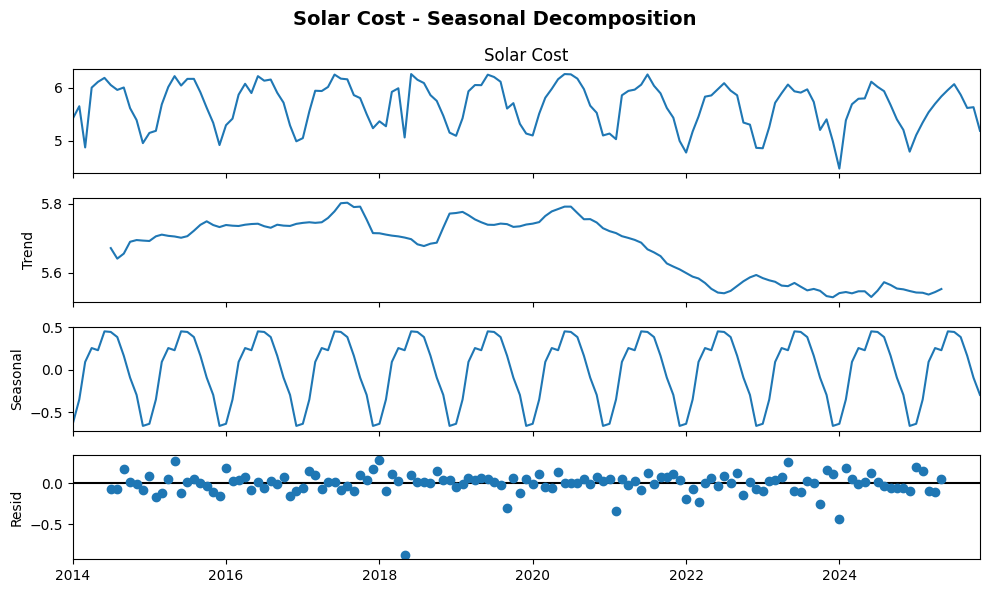


Natural Gas Cost


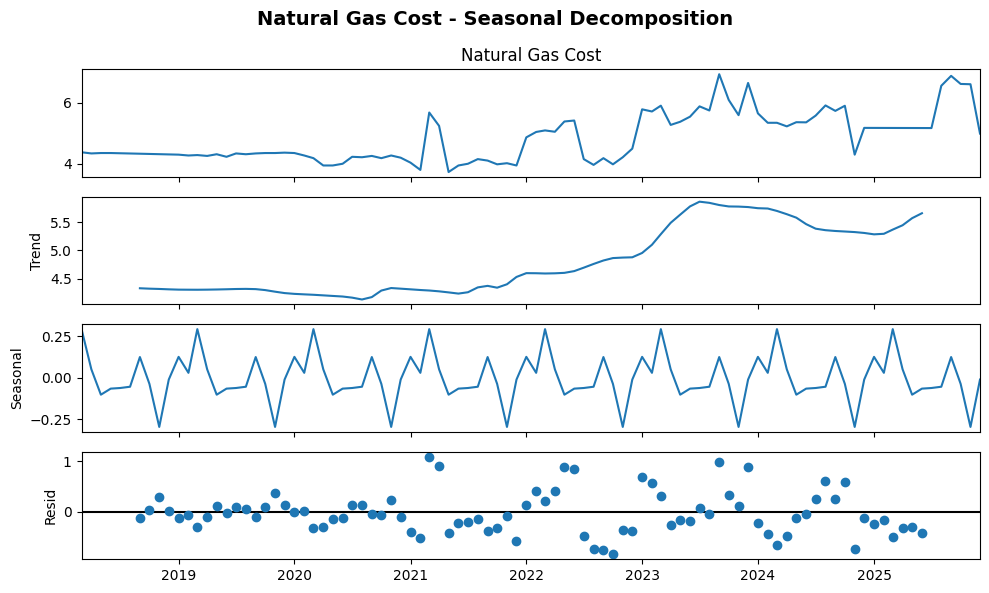

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Decomposition for each energy cost series
for cost_column in cost_columns:
    try:
        print(f"\n{cost_column}")

        # Clean and preprocess
        series = pd.to_numeric(df[cost_column], errors='coerce')
        series = series[series > 0].dropna().asfreq('MS').interpolate()

        if len(series) < 24:
            print(f"Skipping {cost_column} (not enough data).")
            continue

        # Cap extreme outliers
        cap = series.quantile(0.99)
        series = series.clip(upper=cap)

        # Optional log transform for better decomposition clarity
        log_transform = False
        if (series > 0).all() and series.max() / series.min() > 5:
            log_transform = True
            series = np.log(series)

        # Decompose
        decomp = seasonal_decompose(series, model='additive', period=12)

        # Plot result
        fig = decomp.plot()
        fig.suptitle(f"{cost_column} - Seasonal Decomposition", fontsize=14, weight='bold')
        fig.set_size_inches(10, 6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f" Skipping {cost_column} due to error: {e}")


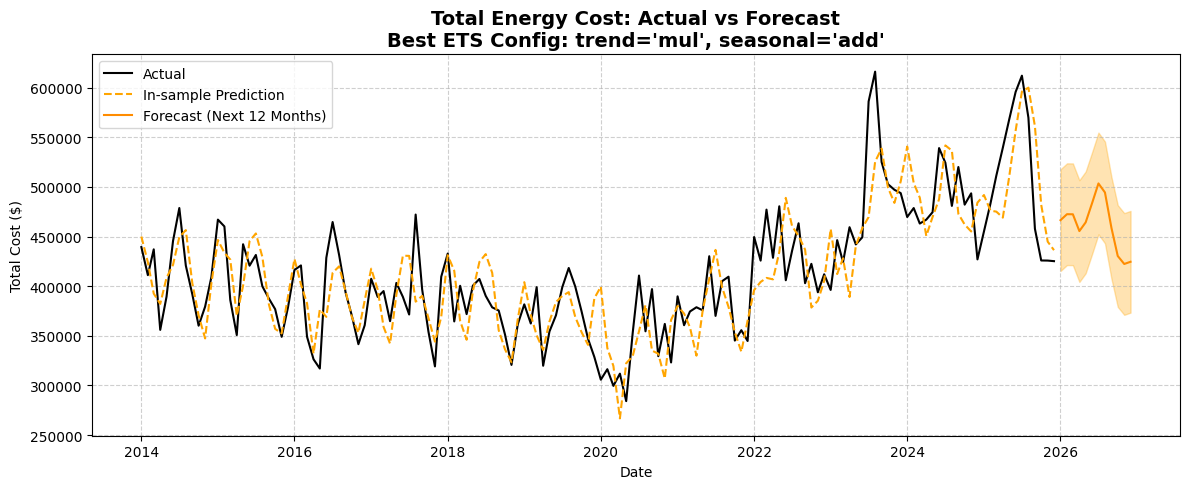

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import DateOffset

df_cleaned = df[cost_columns].apply(pd.to_numeric, errors='coerce')
df_cleaned = df_cleaned.asfreq('MS')
df_cleaned = df_cleaned.interpolate().fillna(method='ffill').fillna(method='bfill')

df_capped = df_cleaned.apply(lambda col: col.clip(upper=col.quantile(0.99)))

total_series = df_capped.sum(axis=1)

log_transform = False
if (total_series > 0).all() and total_series.max() / total_series.min() > 5:
    log_transform = True
    total_series = np.log(total_series)

def best_ets_total(series):
    configs = [('add', 'add'), ('add', 'mul'), ('mul', 'add'), ('mul', 'mul')]
    best_rmse = float('inf')
    best_model_fit = None
    best_config = None

    for trend, seasonal in configs:
        try:
            model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=12)
            fit = model.fit()
            rmse = np.sqrt(((series - fit.fittedvalues) ** 2).mean())
            if rmse < best_rmse:
                best_rmse = rmse
                best_model_fit = fit
                best_config = (trend, seasonal)
        except Exception:
            continue

    return best_model_fit, best_config

model_fit, (trend, seasonal) = best_ets_total(total_series)

forecast = model_fit.forecast(12)
forecast_index = [total_series.index[-1] + DateOffset(months=i) for i in range(1, 13)]
forecast.index = forecast_index
fitted = model_fit.fittedvalues

if log_transform:
    total_series = np.exp(total_series)
    fitted = np.exp(fitted)
    forecast = np.exp(forecast)
    ci = 1.96 * forecast.std()
    lower_bound = forecast - ci
    upper_bound = forecast + ci
else:
    ci = 1.96 * forecast.std()
    lower_bound = forecast - ci
    upper_bound = forecast + ci

plt.figure(figsize=(12, 5))
plt.plot(total_series, label='Actual', color='black')
plt.plot(fitted, label='In-sample Prediction', linestyle='--', color='orange')
plt.plot(forecast, label='Forecast (Next 12 Months)', color='darkorange')
plt.fill_between(forecast.index, lower_bound, upper_bound, color='orange', alpha=0.3)

plt.title(f"Total Energy Cost: Actual vs Forecast\nBest ETS Config: trend='{trend}', seasonal='{seasonal}'", fontsize=14, weight='bold')
plt.xlabel("Date")
plt.ylabel("Total Cost ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
save_path = f"/Users/ecebaltacioglu/my_project/venv_ece/{cost_column.replace(' ', '_')}_forecast.png"
plt.savefig(save_path, dpi=300)
plt.show()


In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import DateOffset
import plotly.graph_objs as go
from dash import Dash, html, dcc, Input, Output, dash_table

df = pd.read_excel("sortedenergy.xlsx", sheet_name="in")
df.columns = df.columns.str.strip()
df['formatted date'] = pd.to_datetime(df['formatted date'])
df.set_index('formatted date', inplace=True)
df = df.sort_index()

cost_columns = ['Steam Cost', 'Electric Cost', 'Chilled Water Cost', 'Solar Cost', 'Natural Gas Cost']
df[cost_columns] = df[cost_columns].apply(pd.to_numeric, errors='coerce')
df[cost_columns] = df[cost_columns].asfreq('MS').interpolate().fillna(method='ffill').fillna(method='bfill')
df['Total Cost'] = df[cost_columns].sum(axis=1)

app = Dash(__name__)

app.layout = html.Div([
    html.H2(" Energy Cost Forecast Dashboard", style={"textAlign": "center", "marginBottom": "1rem"}),
    
    html.Div([
        html.Label("Select Energy Cost Category", style={"fontWeight": "bold"}),
        dcc.Dropdown(
            options=[
                {"label": f"↳ {col}", "value": col} for col in cost_columns
            ] + [{"label": "Total Cost", "value": "Total Cost"}],
            value="Total Cost",
            id="cost-dropdown",
            style={"width": "60%"}
        ),
    ], style={"padding": "1rem"}),

    dcc.Graph(id="forecast-graph"),
    
    html.Div([
        html.H4(" Forecast Table (Next 12 Months)", style={"marginTop": "2rem"}),
        dash_table.DataTable(id="forecast-table", style_table={"overflowX": "auto"})
    ], style={"padding": "1rem"})
])

# ETS tuning logic
def best_ets_model(series, seasonal_periods=12):
    configs = [('add', 'add'), ('add', 'mul'), ('mul', 'add'), ('mul', 'mul')]
    best_rmse = float("inf")
    best_fit = None
    best_config = None
    for trend, seasonal in configs:
        try:
            model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
            fit = model.fit()
            rmse = np.sqrt(((series - fit.fittedvalues) ** 2).mean())
            if rmse < best_rmse:
                best_rmse = rmse
                best_fit = fit
                best_config = (trend, seasonal)
        except:
            continue
    return best_fit, best_config

@app.callback(
    [Output("forecast-graph", "figure"),
     Output("forecast-table", "data"),
     Output("forecast-table", "columns")],
    Input("cost-dropdown", "value")
)
def update_forecast(cost_column):
    series = df[cost_column].copy()
    series = series.asfreq("MS").fillna(method="ffill").fillna(method="bfill")
    series = series.clip(upper=series.quantile(0.99))  # Cap outliers

    log_transform = False
    if (series > 0).all() and series.max() / series.min() > 5:
        log_transform = True
        series = np.log(series)

    model_fit, (trend, seasonal) = best_ets_model(series)
    forecast = model_fit.forecast(12)
    forecast_index = [series.index[-1] + DateOffset(months=i) for i in range(1, 13)]
    forecast.index = forecast_index
    fitted = model_fit.fittedvalues

    # Reverse log transform
    if log_transform:
        series = np.exp(series)
        forecast = np.exp(forecast)
        fitted = np.exp(fitted)

    std_dev = forecast.std()
    lower = forecast - 1.96 * std_dev
    upper = forecast + 1.96 * std_dev

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=series.index, y=series, mode='lines', name="Actual", line=dict(color="black")))
    fig.add_trace(go.Scatter(x=fitted.index, y=fitted, mode='lines', name="In-sample Prediction", line=dict(dash="dash", color="orange")))
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast, mode='lines', name="Forecast", line=dict(color="darkorange")))
    fig.add_trace(go.Scatter(
        x=list(forecast.index) + list(forecast.index[::-1]),
        y=list(upper) + list(lower[::-1]),
        fill='toself',
        fillcolor='rgba(255,165,0,0.2)',
        line=dict(color='rgba(255,165,0,0)'),
        hoverinfo="skip",
        showlegend=True,
        name="95% Confidence Interval"
    ))

    fig.update_layout(
        title=f"{cost_column} Forecast | ETS Config: trend='{trend}', seasonal='{seasonal}'",
        xaxis_title="Date",
        yaxis_title="Cost ($)",
        template="plotly_white",
        legend_title="Legend",
        height=500
    )

    forecast_table = pd.DataFrame({
        "Month": forecast.index.strftime("%b %Y"),
        "Forecasted Cost": forecast.round(2),
        "Lower Bound": lower.round(2),
        "Upper Bound": upper.round(2)
    })

    return fig, forecast_table.to_dict("records"), [{"name": i, "id": i} for i in forecast_table.columns]

app.run_server(debug=True, port=8051)


In [58]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.tseries.offsets import DateOffset
import plotly.graph_objs as go
from dash import Dash, html, dcc, Input, Output

df = pd.read_excel("sortedenergy.xlsx", sheet_name="in")
df.columns = df.columns.str.strip()
df['formatted date'] = pd.to_datetime(df['formatted date'])
df.set_index('formatted date', inplace=True)
df = df.sort_index()

cost_columns = ['Steam Cost', 'Electric Cost', 'Chilled Water Cost', 'Solar Cost', 'Natural Gas Cost']
df[cost_columns] = df[cost_columns].apply(pd.to_numeric, errors='coerce')
df[cost_columns] = df[cost_columns].asfreq('MS').interpolate().fillna(method='ffill').fillna(method='bfill')
df['Total Cost'] = df[cost_columns].sum(axis=1)

def best_ets_model(series, seasonal_periods=12):
    configs = [('add', 'add'), ('add', 'mul'), ('mul', 'add'), ('mul', 'mul')]
    best_rmse, best_fit, best_config = float("inf"), None, None
    for trend, seasonal in configs:
        try:
            model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
            fit = model.fit()
            rmse = np.sqrt(((series - fit.fittedvalues) ** 2).mean())
            if rmse < best_rmse:
                best_rmse, best_fit, best_config = rmse, fit, (trend, seasonal)
        except:
            continue
    return best_fit, best_config

app = Dash(__name__)

app.layout = html.Div([
    html.H2("Energy Cost Forecast Dashboard", style={"textAlign": "center"}),

    html.Div([
        html.Label("Forecast Driver"),
        dcc.Dropdown(
            options=[
                {"label": f"↳ {col}", "value": col} for col in cost_columns
            ] + [{"label": "Total Energy Cost (All Categories)", "value": "Total Cost"}],
            value="Total Cost",
            id="driver-dropdown",
            style={"width": "60%"}
        ),
        html.Label("Apply Scenario (% Change)", style={"marginTop": "1rem"}),
        dcc.Slider(
            id="scenario-slider",
            min=-20,
            max=20,
            step=5,
            value=0,
            marks={i: f"{i}%" for i in range(-20, 25, 5)},
            tooltip={"placement": "bottom"}
        )
    ], style={"padding": "1rem"}),

    dcc.Graph(id="scenario-graph"),

    html.Div([
        html.H4("Scenario Summary", style={"color": "white", "marginBottom": "0.5rem"}),
        dcc.Markdown(
            id="scenario-summary",
            style={
                "paddingLeft": "1rem",
                "marginTop": "0.5rem",
                "color": "white"
            }
        )
    ])
])
@app.callback(
    [Output("scenario-graph", "figure"),
     Output("scenario-summary", "children")],
    [Input("driver-dropdown", "value"),
     Input("scenario-slider", "value")]
)
def update_scenario(driver_column, percent_change):
    adjusted_df = df.copy()
    factor = 1 + (percent_change / 100)

    if driver_column != "Total Cost":
        adjusted_df[driver_column] *= factor
    adjusted_df["Total Cost"] = adjusted_df[cost_columns].sum(axis=1)

    series = adjusted_df["Total Cost"].asfreq("MS").interpolate().fillna(method="ffill")
    series = series.clip(upper=series.quantile(0.99))

    log_transform = False
    if (series > 0).all() and series.max() / series.min() > 5:
        log_transform = True
        series = np.log(series)

    model_fit, (trend, seasonal) = best_ets_model(series)
    forecast = model_fit.forecast(12)
    forecast_index = [series.index[-1] + DateOffset(months=i) for i in range(1, 13)]
    forecast.index = forecast_index
    fitted = model_fit.fittedvalues

    if log_transform:
        series = np.exp(series)
        forecast = np.exp(forecast)
        fitted = np.exp(fitted)

    ci = 1.96 * forecast.std()
    lower, upper = forecast - ci, forecast + ci

    base_series = df["Total Cost"].asfreq("MS").interpolate().fillna(method="ffill").clip(upper=series.quantile(0.99))
    if log_transform:
        base_series = np.log(base_series)
    base_fit, _ = best_ets_model(base_series)
    base_forecast = base_fit.forecast(12)
    if log_transform:
        base_forecast = np.exp(base_forecast)

    base_avg = base_forecast.mean()
    new_avg = forecast.mean()
    delta_pct = (new_avg - base_avg) / base_avg * 100
    peak_value = forecast.max()

    summary_text = f"""
    **Insight Summary**  
    - A {percent_change:+.0f}% change in {driver_column} results in a {delta_pct:+.2f}% change in average monthly total cost  
    - Forecasted peak reaches ${peak_value:,.0f}/month  
    {"- Total cost remains below $500k/month" if peak_value < 500000 else "- Total cost exceeds $500k/month in at least one month"}  
    """

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=series.index, y=series, mode='lines', name="Actual", line=dict(color="black")))
    fig.add_trace(go.Scatter(x=fitted.index, y=fitted, mode='lines', name="In-sample Prediction", line=dict(dash="dash", color="orange")))
    fig.add_trace(go.Scatter(x=forecast.index, y=forecast, mode='lines', name="Forecast", line=dict(color="darkorange")))
    fig.add_trace(go.Scatter(
        x=list(forecast.index) + list(forecast.index[::-1]),
        y=list(upper) + list(lower[::-1]),
        fill='toself',
        fillcolor='rgba(255,165,0,0.2)',
        line=dict(color='rgba(255,165,0,0)'),
        hoverinfo="skip",
        showlegend=True,
        name="95% Confidence Interval"
    ))

    fig.update_layout(
        title=f"Total Cost Forecast (Scenario: {driver_column} {'+' if percent_change >= 0 else ''}{percent_change}%)",
        xaxis_title="Date",
        yaxis_title="Total Cost ($)",
        template="plotly_white",
        height=500)
     
    fig.write_html("graph.html")
    
    return fig, summary_text


if __name__ == '__main__':
    app.run_server(debug=True, port=8052)


In [63]:
df = pd.read_excel("/Users/ecebaltacioglu/my_project/venv_ece/sortedenergy.xlsx", sheet_name="in")
df.columns = df.columns.str.strip()
df['formatted date'] = pd.to_datetime(df['formatted date'])
df.set_index('formatted date', inplace=True)
df = df.sort_index()

cost_columns = ['Steam Cost', 'Electric Cost', 'Chilled Water Cost', 'Solar Cost', 'Natural Gas Cost']
df[cost_columns] = df[cost_columns].apply(pd.to_numeric, errors='coerce')
df[cost_columns] = df[cost_columns].asfreq('MS').interpolate().fillna(method='ffill').fillna(method='bfill')
df['Total Cost'] = df[cost_columns].sum(axis=1)

returns = returns.replace([np.inf, -np.inf], np.nan).dropna()
volatility = returns.std()
volatility.sort_values(ascending=False)

Natural Gas Cost      0.756148
Solar Cost            0.517120
Chilled Water Cost    0.249795
Steam Cost            0.232736
Total Cost            0.119138
Electric Cost         0.118825
dtype: float64

In [80]:
import pandas as pd
import numpy as np
from dash import Dash, html, dcc, Input, Output
import plotly.graph_objs as go

df = pd.read_excel("sortedenergy.xlsx", sheet_name="in")
df.columns = df.columns.str.strip()
df['formatted date'] = pd.to_datetime(df['formatted date'])
df.set_index('formatted date', inplace=True)
df = df.sort_index()

cost_columns = ['Steam Cost', 'Electric Cost', 'Chilled Water Cost', 'Solar Cost', 'Natural Gas Cost']
df[cost_columns] = df[cost_columns].apply(pd.to_numeric, errors='coerce')
df[cost_columns] = df[cost_columns].asfreq('MS').interpolate().fillna(method='ffill').fillna(method='bfill')
df['Total Cost'] = df[cost_columns].sum(axis=1)

returns = df[cost_columns + ['Total Cost']].pct_change().dropna()
latest_values = df.iloc[-1]

external_stylesheets = ["https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css"]
app = Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.H2("Monte Carlo Simulation of Energy Costs", style={
        "textAlign": "center",
        "color": "black"
    }),

    html.Div([
        html.Label("Select Energy Cost Category", style={"fontWeight": "bold", "color": "black"}),
        dcc.Dropdown(
            id="simulation-category",
            options=[{"label": col, "value": col} for col in cost_columns + ['Total Cost']],
            value="Total Cost",
            style={
                "width": "60%",
                "color": "black",
                "backgroundColor": "white",
                "border": "1px solid black",
                "padding": "0.3rem"
            }
        )
    ], style={"padding": "1rem"}),

    dcc.Graph(id="simulation-graph")
], style={"backgroundColor": "white", "color": "black", "paddingBottom": "2rem"})

@app.callback(
    Output("simulation-graph", "figure"),
    Input("simulation-category", "value")
)
def simulate_costs(category):
    np.random.seed(42)
    n_simulations = 100
    n_months = 12
    start_cost = latest_values[category]
    vol = returns[category].std()

    if pd.isna(start_cost) or pd.isna(vol) or vol == 0:
        return go.Figure().update_layout(title="Insufficient data for simulation")

    simulations = np.zeros((n_months, n_simulations))
    for i in range(n_simulations):
        prices = [start_cost]
        for _ in range(n_months - 1):
            change = np.random.normal(0, vol)
            prices.append(prices[-1] * (1 + change))
        simulations[:, i] = prices

    forecast_df = pd.DataFrame(simulations, index=pd.date_range(df.index[-1] + pd.offsets.MonthBegin(1), periods=n_months, freq='MS'))
    median = forecast_df.median(axis=1)
    lower = forecast_df.quantile(0.05, axis=1)
    upper = forecast_df.quantile(0.95, axis=1)

    fig = go.Figure()

    for i in range(min(n_simulations, 30)):
        fig.add_trace(go.Scatter(
            x=forecast_df.index, y=forecast_df.iloc[:, i],
            mode="lines", line=dict(width=0.5, color="gray"), opacity=0.4, showlegend=False
        ))

    fig.add_trace(go.Scatter(x=median.index, y=median, mode="lines", name="Median Forecast",
                             line=dict(color="orange", width=3)))
    fig.add_trace(go.Scatter(
        x=list(lower.index) + list(upper.index[::-1]),
        y=list(lower) + list(upper[::-1]),
        fill="toself",
        fillcolor="rgba(255,165,0,0.3)",
        line=dict(color="rgba(255,165,0,0)"),
        name="90% Confidence Interval"
    ))

    fig.update_layout(
        title=f"Monte Carlo Simulation for {category} (Next 12 Months)",
        xaxis_title="Date",
        yaxis_title="Simulated Cost ($)",
        plot_bgcolor="white",
        paper_bgcolor="white",
        font=dict(color="black"),
        xaxis=dict(color="black"),
        yaxis=dict(color="black"),
        legend=dict(font=dict(color="black")),
        height=500
    )

    return fig

if __name__ == '__main__':
    app.run_server(debug=True, port=8054)
